In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,\
                                    GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor,\
                             RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../data/cleaned_merged_df.csv', index_col = 0)

In [3]:
income_cols = [col for col in df.columns if 'income' in col]
df.drop(columns=income_cols, inplace=True)

**Interpretation:** Income columns will leak data.

In [4]:
df.drop(df.loc[df['median_year_structure_built'] == 0].index, inplace=True)

In [5]:
df.corr()['poverty_rate'].sort_values(ascending=True).head(20)

pct_employed                                                  -0.707169
pct_bachelors_degree_or_higher_25_64                          -0.468676
pct_white                                                     -0.430186
median_rent                                                   -0.428841
owner_occupied_housing_units_lower_value_quartile             -0.427806
owner_occupied_housing_units_median_value                     -0.406843
renter_occupied_housing_units_paying_cash_median_gross_rent   -0.394517
owner_occupied_housing_units_upper_value_quartile             -0.372865
median_age                                                    -0.232440
pct_employed_education_health_social                          -0.208255
white_male_45_54                                              -0.177227
pct_asian                                                     -0.174043
white_male_55_64                                              -0.171020
white_pop                                                     -0

In [6]:
df.corr()['poverty_rate'].sort_values(ascending=False).head(20)

poverty_rate                                  1.000000
gini_index                                    0.591088
pct_black                                     0.479602
death_rate                                    0.277747
pct_amerindian                                0.227037
pct_nonfamily_house                           0.160105
median_year_structure_built                   0.123335
staffed_icu_beds_[per_1000_elderly_(65+)]     0.112316
staffed_icu_beds_[per_1000_adults_(20+)]      0.108958
staffed_all_beds_[per_1000_elderly_(65+)]     0.107186
staffed_icu_beds_[per_1000_people]            0.105337
licensed_all_beds_[per_1000_elderly_(65+)]    0.100839
amerindian_pop                                0.099992
pct_female                                    0.093795
mobile_homes                                  0.074977
pct_children                                  0.068731
licensed_all_beds_[per_1000_adults_(20+)]     0.063920
licensed_all_beds_[per_1000_people]           0.056335
staffed_al

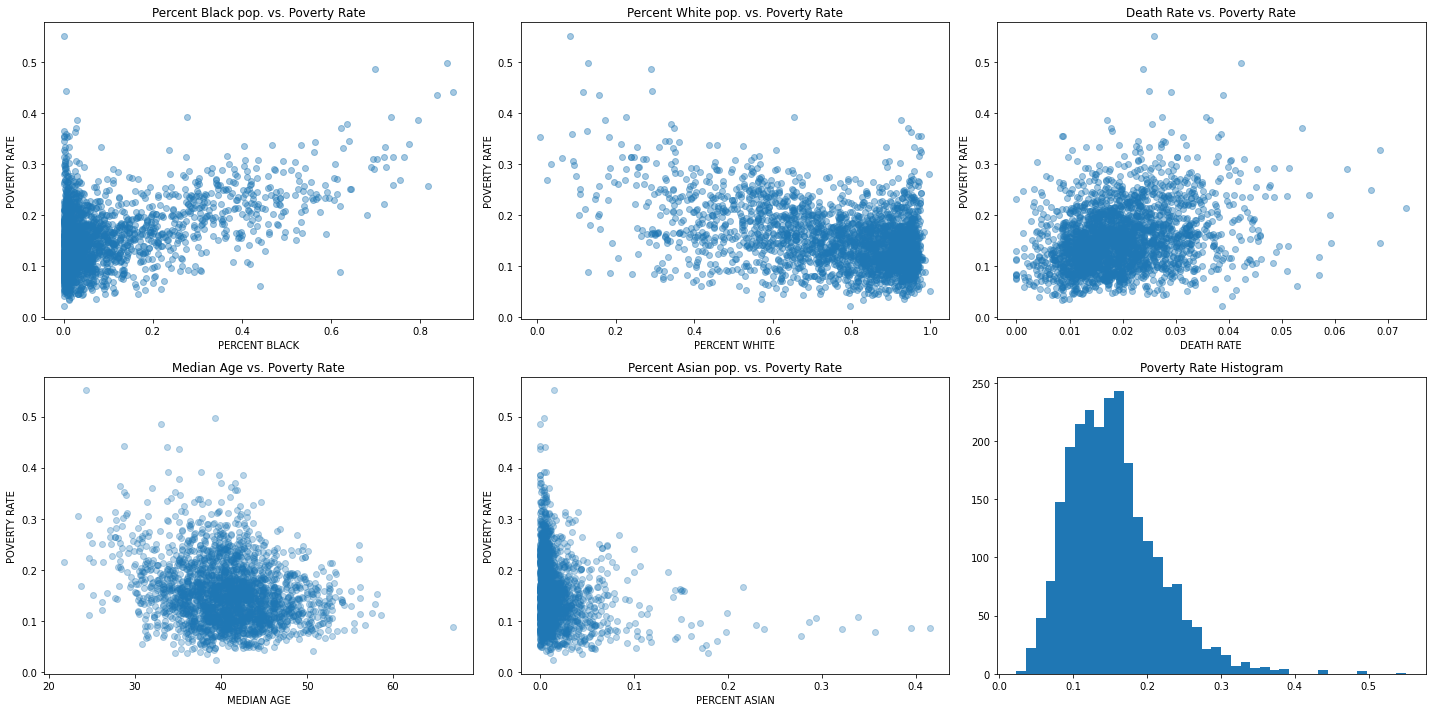

In [181]:
fig, ax = plt.subplots(2,3, figsize = (20,10))

ax[0][0].scatter(df['pct_black'], df['poverty_rate'],
                 alpha = .4)
ax[0][0].set_xlabel('PERCENT BLACK')
ax[0][0].set_ylabel('POVERTY RATE')
ax[0][0].set_title('Percent Black pop. vs. Poverty Rate')

ax[0][1].scatter(df['pct_white'], df['poverty_rate'],
                 alpha = .4)
ax[0][1].set_xlabel('PERCENT WHITE')
ax[0][1].set_ylabel('POVERTY RATE')
ax[0][1].set_title('Percent White pop. vs. Poverty Rate')

ax[0][2].scatter(df['death_rate'], df['poverty_rate'],
                 alpha = .4)
ax[0][2].set_xlabel('DEATH RATE')
ax[0][2].set_ylabel('POVERTY RATE')
ax[0][2].set_title('Death Rate vs. Poverty Rate')

ax[1][0].scatter(df['median_age'], df['poverty_rate'],
                 alpha = .3)
ax[1][0].set_xlabel('MEDIAN AGE')
ax[1][0].set_ylabel('POVERTY RATE')
ax[1][0].set_title('Median Age vs. Poverty Rate')

ax[1][1].scatter(df['pct_asian'], df['poverty_rate'],
                 alpha = .3)
ax[1][1].set_xlabel('PERCENT ASIAN')
ax[1][1].set_ylabel('POVERTY RATE')
ax[1][1].set_title('Percent Asian pop. vs. Poverty Rate')

ax[1][2].hist(df['poverty_rate'], bins=40)
ax[1][2].set_title('Poverty Rate Histogram')

plt.tight_layout()
plt.savefig('../img/poverty_eda');

**Interpretation:** Here we can see there are some correlations with our target. This bodes well for our models. Also there are some outliers. Surprisingly, when outliers that were further than 3 standard deviations away from the mean were removed our models got worse.

In [24]:
X_cols = [col for col in df.columns if 'pct_' in col]
X_cols.remove('pct_not_hispanic')
X_cols.remove('pct_nonfamily_house')
X_cols.remove('pct_male')
X_cols.remove('pct_bachelors_degree_or_higher_25_64')
X_cols.remove('pct_armed_forces')
X_cols.remove('pct_two_or_more_races')
X_cols.remove('pct_commuters_by_public_transportation')
X_cols.remove('pct_employed')
X_cols.remove('pct_children')
X_cols.remove('pct_employed_education_health_social')
X_cols.remove('pct_not_us_citizen_pop')

X_cols.append('death_rate')
X_cols.append('median_year_structure_built')
X_cols.append('median_age')
X_cols.append('all_bed_occupancy_rate')

X = df[X_cols]
y = df['poverty_rate']

In [25]:
X_cols

['pct_family_house',
 'pct_male_male_households',
 'pct_female_female_households',
 'pct_female',
 'pct_white',
 'pct_black',
 'pct_asian',
 'pct_hispanic',
 'pct_amerindian',
 'pct_other_race',
 'death_rate',
 'median_year_structure_built',
 'median_age',
 'all_bed_occupancy_rate']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Random Forest Regressor

In [35]:
rfr = RandomForestRegressor()

params = {
    'n_estimators': [75, 100, 125],
    'max_depth': [3, 4],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [2, 4, 6],
}

gs = GridSearchCV(rfr, param_grid=params, verbose=2, n_jobs = 5)
gs.fit(X_train, y_train)
print('train score', gs.score(X_train, y_train))
print('test score', gs.score(X_test, y_test))
gs.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
train score 0.47150035541580915
test score 0.4452568589319418


{'max_depth': 4,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 125}

In [46]:
rfr = RandomForestRegressor(max_depth=4,
                            min_samples_leaf=4,
                            min_samples_split=4,
                            n_estimators=125)

print(cross_val_score(rfr, X_train, y_train))
rfr.fit(X_train, y_train)
print(rfr.score(X_test, y_test), rfr.score(X_train, y_train))

[0.32014236 0.39798129 0.34629134 0.49079245 0.39133813]
0.4365804180278757 0.4636245091878113


**Interpretation:** This random forest model accounts for 43% of the variability in the data.

In [182]:
def get_errors(model, X, y):

    preds = model.predict(X)

    dummy_preds = np.full(y.shape, y.mean())

    dum_mse = round(mean_squared_error(y*100, dummy_preds*100), 3)
    print('Dummy MSE -- ', f'{dum_mse}%')

    mse = round(mean_squared_error(y*100, preds*100), 3)
    print('Model MSE -- ', f'{mse}%', '\n')

    dum_rmse = round(mean_squared_error(y*100, dummy_preds*100)**.5, 3)
    print('Dummy RMSE -- ', f'{dum_rmse}%')

    rmse = round(mean_squared_error(y*100, preds*100)**.5, 3)
    print('Model RMSE -- ', f'{rmse}%')
    
    return None

get_errors(rfr, X_test, y_test)

Dummy MSE --  37.383%
Model MSE --  21.062% 

Dummy RMSE --  6.114%
Model RMSE --  4.589%


**Interpretation:** The random forest regressors predictions had a mean squared error of 21% when prediction poverty rate as compared to the dummy model which had a mse of 37%. It also improved the root mean squared error. It had a rmse of 4.6% when predicting poverty rate as compared to the dummy model which had an rmse of 6.1%.

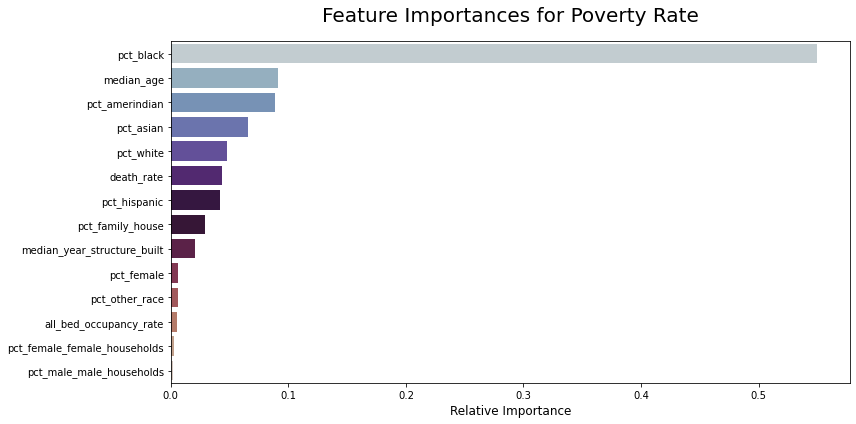

In [197]:
feature_df = pd.DataFrame(rfr.feature_importances_, index=X_train.columns)\
.sort_values(by=0, ascending=False)

plt.figure(figsize=(12, 6))

sns.barplot(x=feature_df[0], y=feature_df.index, palette='twilight')

plt.xlabel('Relative Importance',
           fontsize=12)
plt.title('Feature Importances for Poverty Rate',
          fontsize=20, pad=20)

plt.tight_layout()
plt.savefig('../img/poverty_feature_importances');

**Interpretation:** Percent of the population that is black is by far the most important predictor of poverty rate.

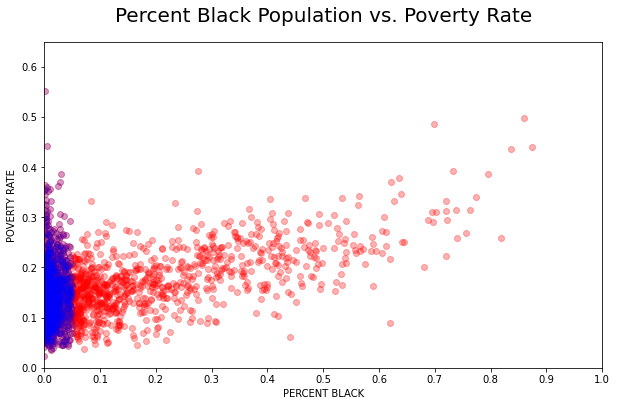

In [198]:
less_1pct_black = df.loc[df['pct_black'] < .05]

a = .3

plt.figure(figsize=(10,6))

plt.scatter(df['pct_black'], df['poverty_rate'], alpha = a, color='r')

plt.scatter(less_1pct_black['pct_black'], less_1pct_black['poverty_rate'],
            alpha = .15, color = 'blue')

plt.title('Percent Black Population vs. Poverty Rate',
          fontsize=20, pad=20)
plt.xlabel('PERCENT BLACK')
plt.ylabel('POVERTY RATE')
plt.xticks([int/10 for int in range(11)])
plt.xlim(0,1.)
plt.ylim(0,.65)
plt.savefig('../img/percent_black_vs_poverty_rate');

**Interpretation:** Below 0.1 there appears to be little correlation between percent black and poverty rate. Above 0.1 the correlation is striking.

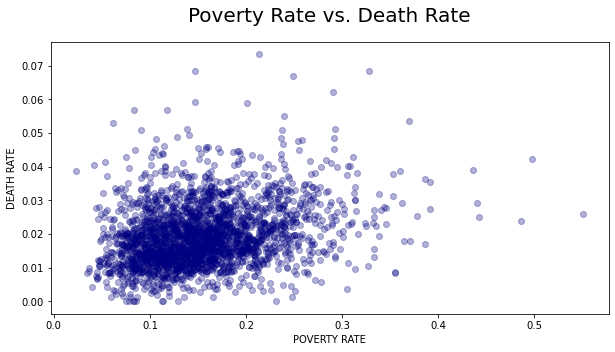

In [199]:
plt.figure(figsize=(10,5))
plt.scatter(df['poverty_rate'], df['death_rate'], alpha = .3,
            c='navy')
plt.xlabel('POVERTY RATE')
plt.ylabel('DEATH RATE')
plt.title('Poverty Rate vs. Death Rate',
          fontsize=20, pad=20)
plt.savefig('../img/poverty_vs_deaths');

### Linear Regression

In [184]:
lr = LinearRegression()
cv_score = cross_val_score(lr, X_train_sc, y_train)
print(cv_score.mean(), cv_score.std())
cv_score

0.42472819234720094 0.0632289227940126


array([0.3887485 , 0.42814378, 0.37770381, 0.54608475, 0.38296011])

In [185]:
lr.fit(X_train_sc, y_train)
print('train score', lr.score(X_train_sc, y_train))
print('test score', lr.score(X_test_sc, y_test))

get_errors(lr, X_test_sc, y_test)

train score 0.44242114422850987
test score 0.4810320898416476


### Lasso

In [189]:
lasso = Lasso(max_iter = 1000, alpha=.00001, tol = 0.0001)
cv_score = cross_val_score(lasso, X_train, y_train)
print(cv_score.mean(), cv_score.std())
cv_score

0.41946387674420205 0.06467869386861236


array([0.37853644, 0.42500964, 0.36281746, 0.54218338, 0.38877247])

In [ ]:


get_errors(lasso, X_test, y_test)

### AdaBoost Regressor

In [38]:
ada = AdaBoostRegressor()

params = {
    'n_estimators': [40, 50, 70, 100],
    'learning_rate': [.01, .001],
    'loss': ['linear', 'square', 'exponential']
}

gs = GridSearchCV(ada, param_grid=params, verbose=3, n_jobs= 5)
gs.fit(X_train, y_train)
print('train score', gs.score(X_train, y_train))
print('test score', gs.score(X_test, y_test))
gs.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
train score 0.36477234175868634
test score 0.33720126409726714


{'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 100}

In [39]:
ada = AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=3,
                                                             min_samples_leaf=10,
                                                             min_samples_split=10,
                                                             n_estimators=75),
                        learning_rate=.001)

ada.fit(X_train, y_train)
print('train score', ada.score(X_train, y_train))
print('test score', ada.score(X_test, y_test))

train score 0.3906972744453324
test score 0.37597223452858153


### Gradient Boosting Regressor

In [40]:
gbr = GradientBoostingRegressor()

params = {
    'loss': ['ls', 'lad', 'huber'],
    'learning_rate': [.001, .001],
    'n_estimators': [120, 200, 250],
    'max_depth': [2, 3, 4]
}

gs = GridSearchCV(gbr, param_grid=params, verbose=3, n_jobs= 5)
gs.fit(X_train, y_train)
print('train score', gs.score(X_train, y_train))
print('test score', gs.score(X_test, y_test))
gs.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
train score 0.16209881090348832
test score 0.13297466643943945


{'learning_rate': 0.001, 'loss': 'ls', 'max_depth': 4, 'n_estimators': 250}

In [41]:
df['pct_black'].max(), df['poverty_rate'].max()

(0.8741228070175439, 0.5509650180940893)